## Fera Formidável 4.2
### Stop right now, thank you very much
#### Rômulo 24024

### Enunciado:
**Objetivo:** implemente uma estratégia de Parada Antecipada (Early Stopping) no
processo de treino da rede neural feita em Python puro ou no processo de treino da rede
neural feita em PyTorch

**Comentário:** esta não é para resolver com o módulo lightning.

### Introdução:
**Early stopping** é uma técnica de regularização usada no treinamento de redes neurais para evitar overfitting. Ela interrompe o treinamento quando a performance no conjunto de validação começa estagna ou começa a piorar. Isso preserva o modelo no ponto em que ele é mais geral.

Implementarei uma estratégia de Parada Antecipada (Early Stopping). Para isso, implementarei uma forma de obter um ponto de checagem (checkpoint) e uma forma de utilizar estes parâmetros de viéses e pesos para reobter os resultados.

#### Imports necessários:

In [1]:
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

dados = pd.read_csv('http://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv').dropna()

#### Classes da Rede Neural  em python puro:

In [2]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = np.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    def log(self):
        """Calcula o logaritmo natural do número"""
        progenitor = (self,)
        data = math.log(self.data)
        resultado = Valor(data, progenitor, "log")

        def propagar_log():
            self.grad += resultado.grad * (1 / self.data)

        resultado.propagar = propagar_log
        return resultado

    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    def __rsub__(self, outro_valor):
        """Realiza a operação: outro_valor - self"""
        return outro_valor + (-self)
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        e_neg = (-self).exp()
        return Valor(1) / (Valor(1) + e_neg)

    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

A classe MLP foi ajustada para receber os parâmetros, para que após o checkpoint, possamos recuperar o melhor modelo.
Estes parâmetros serão recebidos na forma de lista, que será salva a partir da instância params. Cada camada receberá os parâmetros de acordo número de pesos e de vieses, o npumero de viéses sempre será o número de neurônios da camada.

In [3]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada, parametros=None):
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        camadas = []
        
        indice = 0 # índice inicial para aplicar os pesos de viéses corretamente nos neurônios
        if parametros is None:
            for i in range(len(num_neuronios_por_camada)):
                camada = Camada(num_neuronios_por_camada[i], percurso[i])
                camadas.append(camada)
        else:
            for i in range(len(num_neuronios_por_camada)):
                # calculamos o numero de pesos, cada neurônio tem um peso associado a cada dados de entrada e um único viés
                num_pesos = percurso[i] * num_neuronios_por_camada[i]
                num_vieses = num_neuronios_por_camada[i]
                
                camada_parametros = parametros[indice: indice + num_pesos + num_vieses]
                camada = Camada(num_neuronios_por_camada[i], percurso[i], camada_parametros)
                camadas.append(camada)
                
                indice += num_pesos + num_vieses # desta forma, garantimos que mesmo as camadas tendo numero de neuronios
                #  diferentes, os parametros ainda serão distribuidos corretamente
        
        self.camadas = camadas
    def __call__(self, x, ):
        for camada in self.camadas:
            x = camada(x)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

A classe camada também será atualizada para poder propagar os parâmetros recebidos na MLP para os neurônios, eles devem estar ajustados de forma que o neurônio receba somente os parâmetros referentes a ele, portanto, haverá parâmetros de pesos para cada dado de entrada do neurônio e um parâmetro de viés para cada neurônio, que sempre será o pultimo da lista.

In [4]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada, parametros=None):
        neuronios = []
        indice = 0
        if parametros is None:
            for _ in range(num_neuronios):
                neuronio = Neuronio(num_dados_entrada)
                neuronios.append(neuronio)
        else:
            for _ in range(num_neuronios):
                # os parâmetros já vem organizados a partir da MLP, só devemos distribuí-los corretamente em cada neurônio
                neuronio_parametros = parametros[indice: indice + num_dados_entrada + 1] # +1, critério de parada é excludente
                neuronio = Neuronio(num_dados_entrada, neuronio_parametros)
                neuronios.append(neuronio)
                indice += num_dados_entrada + 1 # atualizando o indice, não atualizo o indice no for, pois se for multiplicá-lo
                # pelo numero de dados de entrada posteriormente, irei aumentado de dados de entrada em dados de entrada
        
        self.neuronios = neuronios
    def __call__(self, x):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida 
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

Na classe neurônio, se os parâmetros forem dados, não necessitaremos gerar os pesos e viéses aleatoriamente. No lugar, usaremos os parâmetros fornecidos por camada, o último parâmetro sera o viés e os demais os pesos, que serão associados corretamente a cada neurônio.

In [5]:
class Neuronio:
    def __init__(self, num_dados_entrada, parametros=None):
        if parametros is None:
            self.vies = Valor(random.uniform(-1, 1))
            self.pesos = [Valor(random.uniform(-1, 1)) for _ in range(num_dados_entrada)]
        else:
            # Aplicamos os pesos já separados adequadamente em camada, o viés sempre será o último, os pesos os anteriores
            self.pesos = parametros[:-1]
            self.vies = parametros[-1]

    def __call__(self, x):
        assert len(x) == len(self.pesos)
        soma = Valor(0)
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
        soma += self.vies
        dado_de_saida = soma.sig()
        return dado_de_saida

    def parametros(self):
        return self.pesos + [self.vies]

#### Tratando os dados:
Selecionaremos as seguintes features:
- Comprimento do bico
- Comprimento da nadadeira
- Massa corporal
- Ano de análise

Após isso, faremos a normalização e criaremos o modelo MLP.

In [6]:
x = ['bill_length_mm', 'flipper_length_mm','body_mass_g']
y = ['bill_depth_mm']

x = dados.loc[:,x].values # Seleção do x com base nos features
y_true = dados.loc[:,y].values # Seleção do y_true com base no target

# Normalização:
x_scaler = StandardScaler() # usarei o standar scaler
x_scaler.fit(x)
 
y_scaler = StandardScaler()
y_scaler.fit(y_true)
 
x = x_scaler.transform(x).tolist()
y_true = y_scaler.transform(y_true).tolist()

x = [[Valor(x__) for x__ in x_] for x_ in x]
y_true = [Valor(y_true_[0]) for y_true_ in y_true]

# Arquitetura MLP:
NUM_DADOS_DE_ENTRADA = 3 
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [5, 6, 3]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede) # Criando MLP

Treinando o modelo com checkpoint:

In [ ]:
NUM_EPOCAS = 100000
TAXA_DE_APRENDIZADO = 0.7
PACIENCIA = 3
checkpoint = [-1, float('inf')] # Para o primeiro treino já substituir o checkpoint
loss = Valor(0) # Para o critério de parada
losses = [] # Para plots futuros
count = 0

for epoca in range(NUM_EPOCAS):
    # meu criterio de parada do early stopping
    if count == PACIENCIA:
        break

    loss_antigo = loss.data

    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)

    # loss
    erros = []
    for yt, yp in zip(y_true, y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)/len(erros)

    if loss.data < checkpoint[1]:
        checkpoint = [epoca, loss.data]
        for p in minha_mlp.parametros():
            checkpoint.append(p)

    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

    print(epoca, loss.data)
    losses.append(loss)
    # Isto permite que o early topping ocorra
    if abs(loss_antigo - loss.data) < TAXA_DE_PACIENCIA:
        count += 1
    else:
        count = 0

0 1.1294941058638843
1 1.0901050726191674
2 1.066714497761123
3 1.051906677816773
4 1.041937357092405
5 1.0348717832443814
6 1.0296517528217375
7 1.0256633845638343
8 1.0225312278945249
9 1.020014946579823
10 1.017954584436707
11 1.016240074980293
12 1.014793478357807
13 1.0135582162897236
14 1.0124923175733382
15 1.0115640482855155
16 1.0107490071298224
17 1.0100281476025474


Exibindo nosso checkpoint:

In [13]:
checkpoint

[17,
 np.float64(1.0100281476025474),
 Valor(data=-0.6734208681378159),
 Valor(data=0.7582469609674566),
 Valor(data=-0.7463300485878687),
 Valor(data=-0.9960362514817394),
 Valor(data=-0.010756501293098245),
 Valor(data=-0.22047522950902376),
 Valor(data=-0.6256181386133504),
 Valor(data=-0.8135711220749172),
 Valor(data=-0.5142416639488646),
 Valor(data=-0.5935103954302333),
 Valor(data=0.6328061310557054),
 Valor(data=0.35745726738638284),
 Valor(data=0.6766221944636145),
 Valor(data=0.8453014325623713),
 Valor(data=0.10177374611118471),
 Valor(data=0.8455921859235122),
 Valor(data=0.46831879697305523),
 Valor(data=-0.29210524956886397),
 Valor(data=-0.5459304614437923),
 Valor(data=0.8851246682659983),
 Valor(data=-0.47359615449428427),
 Valor(data=0.2255803754240293),
 Valor(data=-0.8876836569417985),
 Valor(data=0.4901584253830537),
 Valor(data=-0.3601731099906037),
 Valor(data=-0.1440328920073826),
 Valor(data=-0.4222605800246556),
 Valor(data=-0.6028279453610185),
 Valor(data=0

Recriando minha MLP com mesmos parâmetros:

In [14]:
minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede,checkpoint[2:])

In [15]:
y_pred = []
comparativo = []
for exemplo in x:
    previsao = minha_mlp(exemplo)
    y_pred.append(previsao)

# loss
erros = []
for yt, yp in zip(y_true, y_pred):
    residuo = yp - yt
    erro_quadratico = residuo ** 2
    erros.append(erro_quadratico)        
loss = sum(erros)/len(erros)

# zero grad
for p in minha_mlp.parametros():
    p.grad = 0

# backpropagation
loss.propagar_tudo()

# atualiza parâmetros
for p in minha_mlp.parametros():
    p.data = p.data - p.grad * TAXA_DE_APRENDIZADO

# mostra resultado (opcional)
print(loss.data)
print([p for p in minha_mlp.parametros()])

1.0088117050300958
[Valor(data=-0.6737440469065985), Valor(data=0.7576266771822613), Valor(data=-0.746783403379506), Valor(data=-0.9961145012035479), Valor(data=-0.01053465532476586), Valor(data=-0.21988578185512286), Valor(data=-0.625192646722108), Valor(data=-0.813690695429462), Valor(data=-0.5149740498672775), Valor(data=-0.5954273540051637), Valor(data=0.6312048924653655), Valor(data=0.35697197242234047), Valor(data=0.6767880809055689), Valor(data=0.8456002510456102), Valor(data=0.10196811205458017), Valor(data=0.8454948632847676), Valor(data=0.4684425869206533), Valor(data=-0.29193182983856997), Valor(data=-0.5458115375095453), Valor(data=0.8851262093984186), Valor(data=-0.47352638008812037), Valor(data=0.2254199203508812), Valor(data=-0.8875647678531594), Valor(data=0.4909303613660048), Valor(data=-0.3601193470881552), Valor(data=-0.14358409125938043), Valor(data=-0.4222588599303631), Valor(data=-0.6027513163680865), Valor(data=0.8573222211926056), Valor(data=0.9835503290414246),

Vamos ver se deu certo:

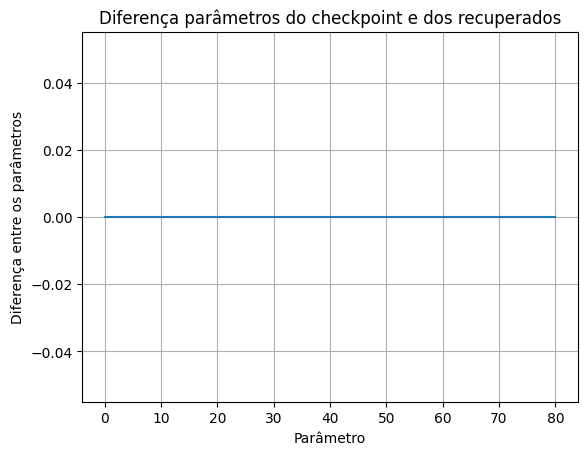

In [16]:
comparativo = [p for p in minha_mlp.parametros()]
diferencas = [p.data - cp.data for p, cp in zip(comparativo, checkpoint[2:])]

plt.plot(diferencas)
plt.title("Diferença parâmetros do checkpoint e dos recuperados")
plt.xlabel("Parâmetro")
plt.ylabel("Diferença entre os parâmetros")
plt.grid()
plt.show()

#### Plotando a perda dos valores originais:

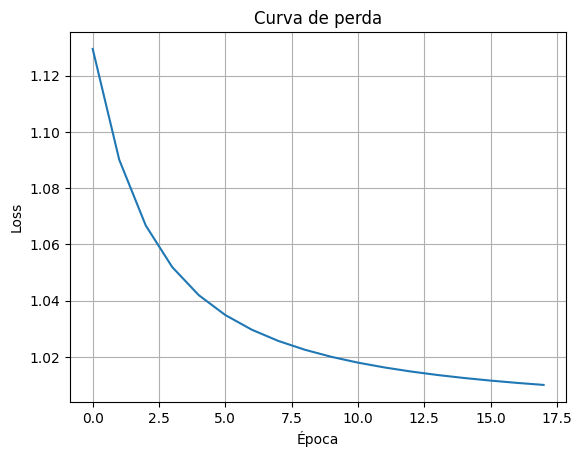

In [18]:
plt.plot(range(epoca),[loss.data for loss in losses])
plt.title("Curva de perda")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.grid()
plt.show()

Podemos perceber que o número de épocas está reduzido em relação ao instanciado, evidenciando que o early stopping ocorreu.

Transformando o que nós fizemos em uma classe organizada, para melhor conversar com o pytorch:
Uma classe me pareceu melhor pois as estruturas no pytorch estão organizadas assim, e podemos armazenar o counter localmente, numa função necessitaríamos uma variável externa que ficasse atualizando continuamente.
Posso adicionar uma instância de checkpoint para receber os parâmetros de best score futuramente.

In [ ]:
# Nesta função não utilizei a comparação com taxa de paciência, pois me pareceu desnecessário
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience # Paciência
        self.counter = 0 # O nosso counter para comparação
        self.best_score = float('inf') # Devemos iniciar 
        self.stop = False # Quando for true, o early stopping deve ocorrer

    def __call__(self, val_loss): # Call da nossa função
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True # Deve ser adicionado externamente que se a instância for true, o early stopping ocorre

### Conclusão:
O código implementa uma rede neural em Python puro com suporte a Parada Antecipada (Early Stopping), conforme o enunciado. Essa estratégia interrompe o treinamento quando a perda não melhora significativamente, evitando overfitting e economizando recursos. Checkpoints garantem a recuperação dos melhores parâmetros do modelo. A implementação demonstrou eficiência ao reduzir o número de épocas necessárias, mantendo a qualidade do modelo.

### Referências

- "Regularization by Early Stopping."

Disponível em: <https://www.geeksforgeeks.org/regularization-by-early-stopping/>

- "Early stopping is a form of regularization that halts the training process when the performance of the model on a validation dataset starts to degrade."

Disponível em: <https://www.geeksforgeeks.org/using-early-stopping-to-reduce-overfitting-in-neural-networks/>

- Classes da MLP em Python puro

 Obtidos em: ATP-303 NN 4.2 - Notebook MLP.ipynb